# Calculating short spectra

We start by importing the necessary libraries. Including the module ``specwizard.Phys`` that contains the ``ReadPhys`` function that contains a set of physical constants.

In [1]:
import specwizard
import numpy as np
from specwizard import Phys
import matplotlib.pyplot as plt
constants = Phys.ReadPhys()

first
This class defines the B-spline kernel of Monaghan and Lattanzio, as used in Gadget-2


As always, the first step of for doing calculations. We initilize the ``specwizard.Build_Input`` module to generate the ``Wizard`` dictionary, in this case we will load it from a ``YAML`` file using the ``read_from_yml`` function. 

In [2]:
build_input = specwizard.Build_Input()

In [3]:
Wizard = build_input.read_from_yml(yml_file='Wizard.yml')

Warning! SightLength NOT found. Setting default value: 1


Now we can simply run ``specwizard.GenerateShortSpectra``.  This will read the simulation data and according to the parameters given in the ``Wizard`` dictionary will form a sight line, and load all the necessary information for the calculation of the optical depth.  Later the sightline particles physical properties are projected into velocity pixels. These properties will be weighted by the total mass of particles that are contributing to a specific pixel, by the fraction of each element and by ion. Finally with this projection we will calculate the Optical Depth of each ion that was asked in the ``Wizard `` dictionary. 

When we run ``specwizard.GenerateShortSpectra`` it will return ``optical_depth,projected_data,sim_data`` which are python dictionaries that contains the informaiton of each of the step described above. If one desire to just use one of the data the assigned python charecter ``_`` can be used, for example if only we care about the optical depth we can use ``OD,_,_ = specwizard.GenerateShortSpectra(Wizard)``



In [4]:
optical_depth,projected_data,snap_data = specwizard.GenerateShortSpectra(Wizard=Wizard)

/cosma7/data/dp004/dc-aram1/pyspecwizard_main/gitcontrol/specwizard/specwizard/specwizard/SpecWizard_ComputeOpticaldepth.py:294: RuntimeWarning: invalid value encountered in sqrt
  bions_kms = np.sqrt(2 * self.constants["kB"] * Tions / weight) / 1e5


In [10]:
snap_data['Particles']['Densities']

{'Value': array([0.616979  , 0.26902097, 0.5525248 , ..., 2.3348951 , 2.4020216 ,
        3.1862082 ], dtype=float32),
 'Info': {'CGSConversionFactor': 6.769911178294543e-31,
  'VarDescription': 'Ion mass-densities',
  'aexp-scale-exponent': -3.0,
  'h-scale-exponent': 2.0}}

In [9]:
projected_data['Mass-weighted']['Densities']

{'Value': array([1.73718766, 1.57875629, 1.38362337, ..., 1.92713224, 1.91495362,
        1.85163886]),
 'Info': {'CGSConversionFactor': 6.769911178294543e-31,
  'VarDescription': 'Ion mass-densities',
  'aexp-scale-exponent': -3.0,
  'h-scale-exponent': 2.0}}

To illustrate the outputs we will generate a set of plots that shows the different contents from the returned dictionaries. 

In [36]:
positions         = snap_data["Particles"]["Positions"] # We load the positions from the simulation data LOS 
densities         = snap_data["Particles"]["Densities"] # We do the same for the density 
projected_density = projected_data["Mass-weighted"]['Densities']['Value'] # We load the Mass-weighted density from the projected pixel data. 
OD           = optical_depth[('Hydrogen', 'H I')]['Optical depths']['Value'] # We load the Optical depth
elementnames = Wizard["ionparams"]["Ions"] # We get the name of the ions that we used 

We can examine what is inside these fields: 

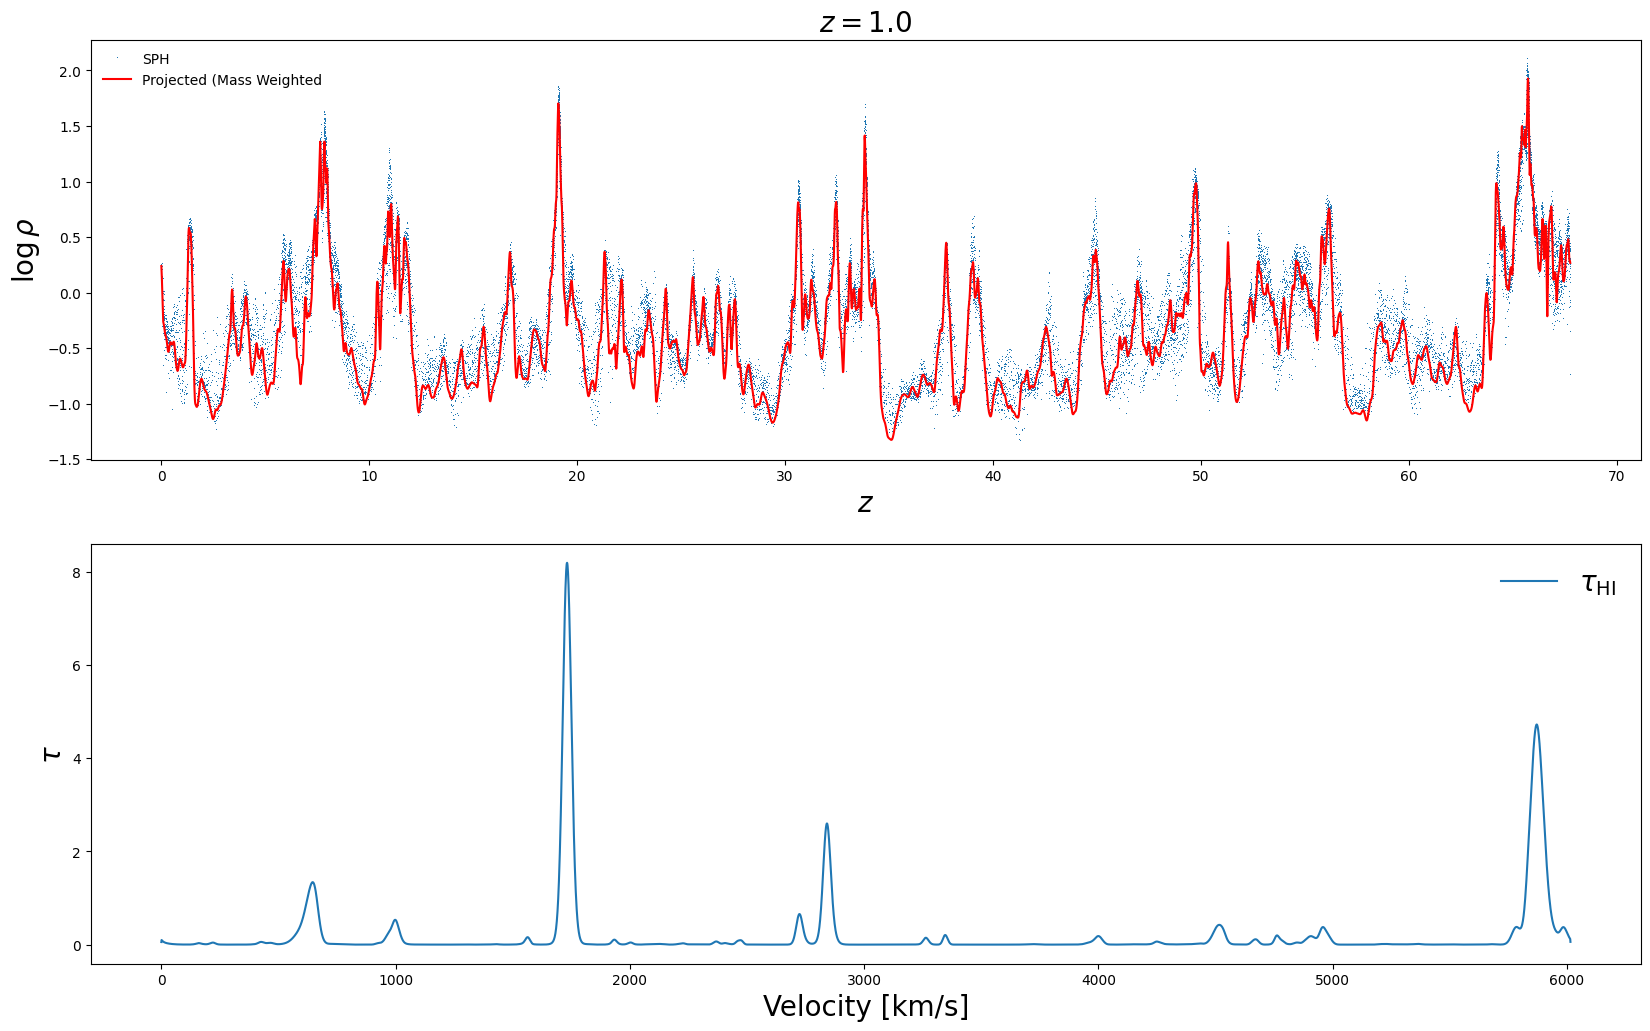

In [44]:

fontsize= 20
ix           = Wizard['sightline']["x-axis"] ; iy = Wizard['sightline']["y-axis"] ; iz = Wizard['sightline']["z-axis"]
positions    = snap_data["Particles"]["Positions"]
densities    = snap_data["Particles"]["Densities"]
OD           = optical_depth[('Hydrogen', 'H I')]['Optical depths']['Value']
elementnames = Wizard["ionparams"]["Ions"]
#
zpos = positions["Value"][:,iz]
rho  = densities["Value"]

# parameters of projection
pixz = projected_data["pixel"]["Value"] * np.arange(projected_data["npix"])
                   
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

title = r"$z=$"+str(round(Wizard["Header"]["Cosmo"]["Redshift"],2))

# plot particle density
ax[0].set_title(title, fontsize=fontsize)
ax[0].plot(zpos, np.log10(rho), ',', label='SPH')
ax[0].plot(pixz, np.log10(projected_data["Mass-weighted"]['Densities']['Value']), color='r', label='Projected (Mass Weighted')
ax[0].legend(frameon=False)
ax[0].set_ylabel(r"$\log\rho$", fontsize=fontsize)
ax[0].set_xlabel(r"$z$", fontsize=fontsize)



ax[1].plot(OD, label=r'$\tau_{\mathrm{H I}}$')

ax[1].legend(frameon=False, fontsize=fontsize)



ax[1].set_ylabel(r"$\tau$", fontsize=fontsize)
ax[1].set_xlabel(r"Velocity [km/s]", fontsize=fontsize)

fig.show()

    




We can take a deeper look at the output ``project_data`` to understand better the output. We project the physical properties of the simulation particles into velocity pixels. This projection is weighted by the total mass of the particles contributing to a pixel, by it's element content and by the ion content. 

/tmp/ipykernel_401330/1416116103.py:11: RuntimeWarning: invalid value encountered in divide
  ratio               = ion_fraction / element_density


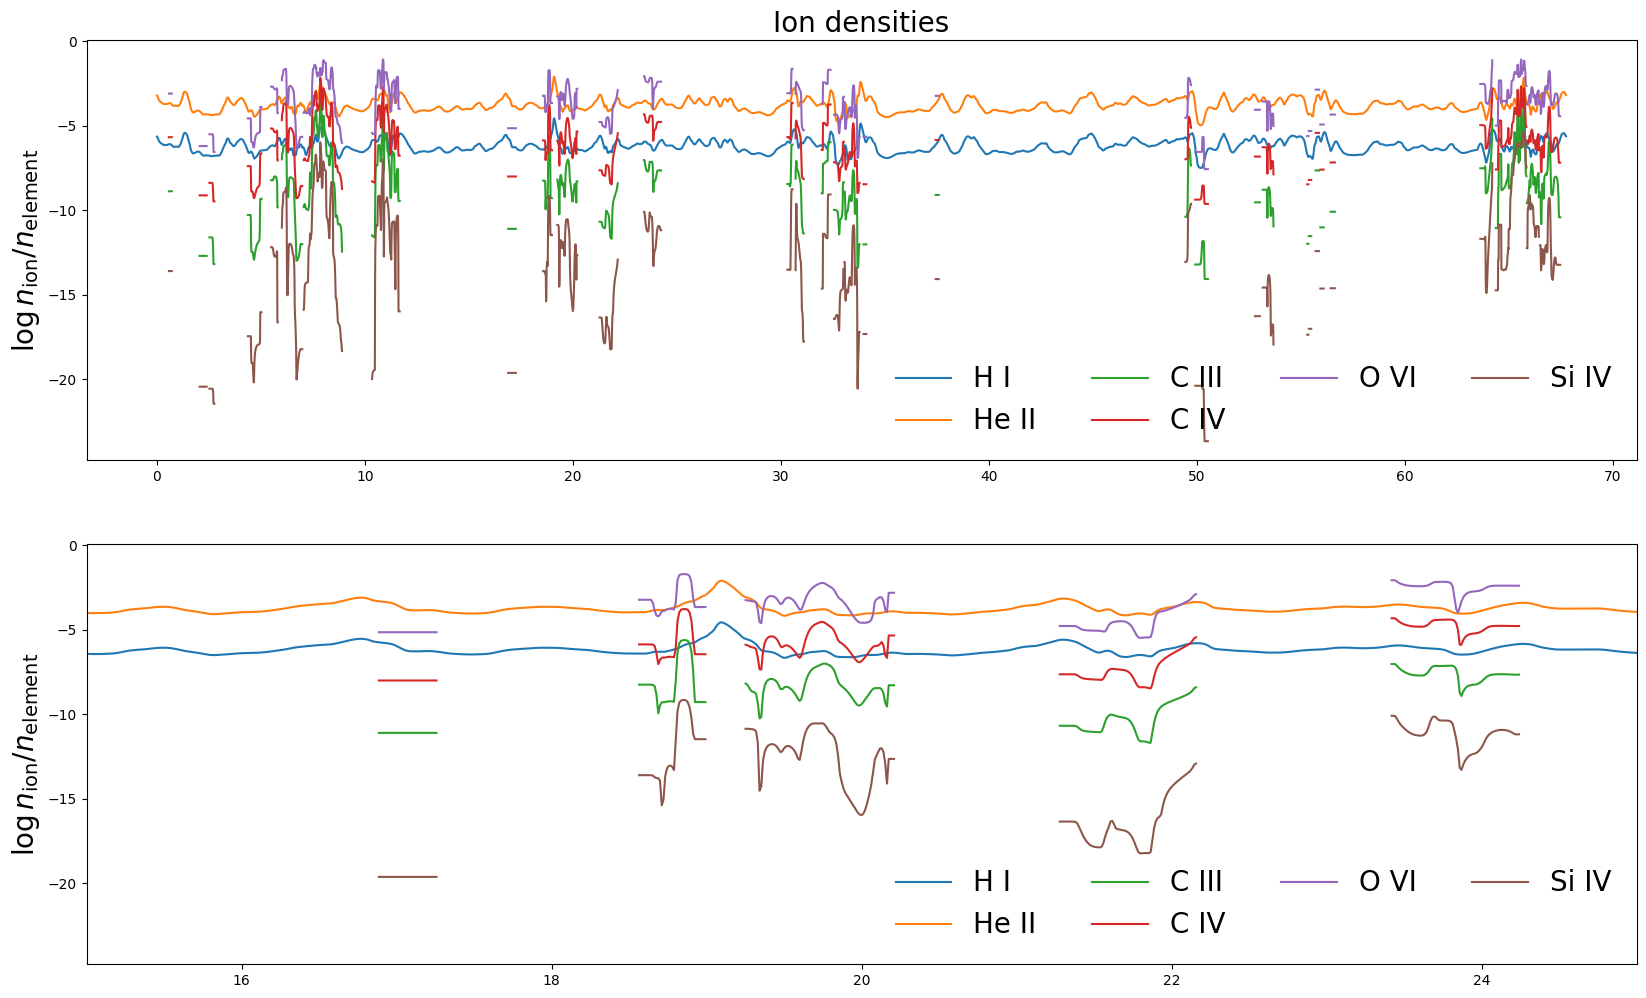

In [37]:
# plot ionization states
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

# plot ion densities
ax[0].set_title("Ion densities", fontsize=fontsize)
for i in np.arange(2):
    for (isys, (element, ion)) in zip(nsys, elementnames):
        color               = cycle[isys]
        element_density     = projected_data["Element-weighted"][element]['Densities']['Value']
        ion_fraction        = projected_data["Ion-weighted"][ion]['Densities']['Value']
        ratio               = ion_fraction / element_density
        ax[i].plot(pixz, np.log10(ratio), color=color, label=r'{}'.format(ion))
    # ax[i].set_ylim(-7,1)
    ax[i].legend(frameon=False, fontsize=fontsize, ncol=4)
    ax[i].set_ylabel(r"$\log n_{\rm ion}/n_{\rm element}$", fontsize=fontsize)
ax[1].set_xlim(15, 25)
    
    
fig.show()

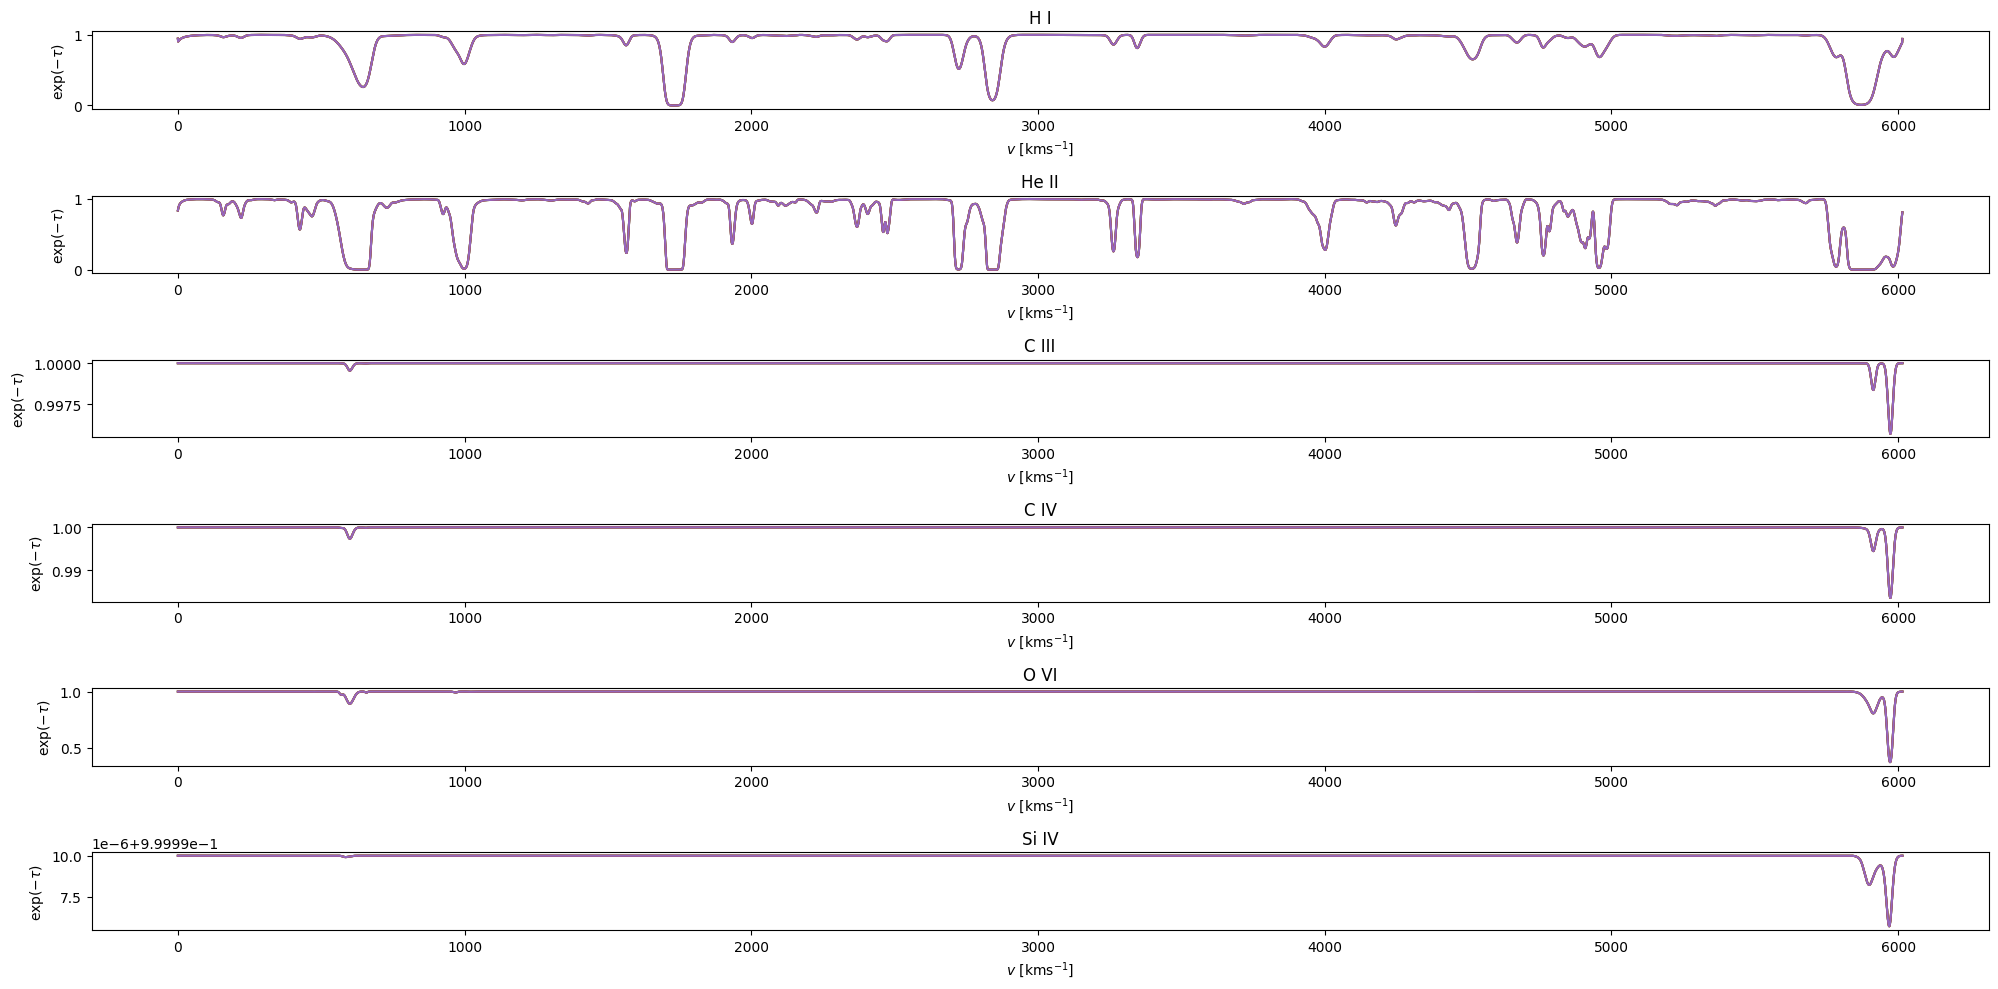

In [68]:
Numof_Ions = len(elementnames)
fig, ax  = plt.subplots(Numof_Ions, 1, figsize = (20, 10))

for (i, ion) in zip (np.arange(Numof_Ions), elementnames):
#    ax[i].set_xlim(0, box_kms)
    try:
        for j in range(5):
            ax[i].plot(( np.exp(-optical_depth[ion]['Optical depths']['Value'])),label = 'sightline# '+str(j))
    except:
        continue
    element, ion_name = ion
    title = r"{}".format(ion_name)
    ax[i].set_title(title)
    ax[i].set_ylabel(r"$\exp(-\tau)$")
    ax[i].set_xlabel(r"$v\ [{\rm km s}^{-1}]$")
   # ax[i].set_xlim(6200,6800)
fig.tight_layout()
fig.show()


In [11]:
import unyt

In [12]:
unyt.M_sun_cgs

unyt_quantity(1.98841586e+33, 'g')

In [13]:
unyt.G_cgs

unyt_quantity(6.67408e-08, 'cm**3/(g*s**2)')

In [23]:
from unyt import unyt_array

In [24]:
data = [5,56185,84,2,3,489]

In [25]:
msols = unyt_array(data,unyt.Msun)

In [32]:
msols.convert_to_cgs()

unyt_array([9.94207930e+33, 1.11719145e+38, 1.67026932e+35, 3.97683172e+33,
       5.96524758e+33, 9.72335356e+35], 'g')